# PREDICCIÓN DE LA PRODUCCIÓN DE ENERGÍA SOLAR


# Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import pickle

# Librerías de métricas
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Librerías de modelos
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import PredefinedSplit

# Librerías de búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV


# Importación de datos

In [2]:
disp_df = pd.read_csv("datos/disp_st2ns1.txt.bz2",
    compression="bz2",
    index_col=0)

# Analisis Exploratorio de Datos

Comprobamos la cantidad de datos que tenemos en el dataset

In [3]:
disp_df_eda = disp_df.copy()

print('Cantidad de Filas y columnas:', disp_df_eda.shape)
print('Nombre columnas:', disp_df_eda.columns)

Cantidad de Filas y columnas: (4380, 76)
Nombre columnas: Index(['apcp_sf1_1', 'apcp_sf2_1', 'apcp_sf3_1', 'apcp_sf4_1', 'apcp_sf5_1',
       'dlwrf_s1_1', 'dlwrf_s2_1', 'dlwrf_s3_1', 'dlwrf_s4_1', 'dlwrf_s5_1',
       'dswrf_s1_1', 'dswrf_s2_1', 'dswrf_s3_1', 'dswrf_s4_1', 'dswrf_s5_1',
       'pres_ms1_1', 'pres_ms2_1', 'pres_ms3_1', 'pres_ms4_1', 'pres_ms5_1',
       'pwat_ea1_1', 'pwat_ea2_1', 'pwat_ea3_1', 'pwat_ea4_1', 'pwat_ea5_1',
       'spfh_2m1_1', 'spfh_2m2_1', 'spfh_2m3_1', 'spfh_2m4_1', 'spfh_2m5_1',
       'tcdc_ea1_1', 'tcdc_ea2_1', 'tcdc_ea3_1', 'tcdc_ea4_1', 'tcdc_ea5_1',
       'tcolc_e1_1', 'tcolc_e2_1', 'tcolc_e3_1', 'tcolc_e4_1', 'tcolc_e5_1',
       'tmax_2m1_1', 'tmax_2m2_1', 'tmax_2m3_1', 'tmax_2m4_1', 'tmax_2m5_1',
       'tmin_2m1_1', 'tmin_2m2_1', 'tmin_2m3_1', 'tmin_2m4_1', 'tmin_2m5_1',
       'tmp_2m_1_1', 'tmp_2m_2_1', 'tmp_2m_3_1', 'tmp_2m_4_1', 'tmp_2m_5_1',
       'tmp_sfc1_1', 'tmp_sfc2_1', 'tmp_sfc3_1', 'tmp_sfc4_1', 'tmp_sfc5_1',
       'ulwrf_s1_1

Comprobamos si existen missing values en los datos; para ello utilizamos el método .info()

In [4]:
disp_df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4380 entries, V1 to V4380
Data columns (total 76 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   apcp_sf1_1  4380 non-null   float64
 1   apcp_sf2_1  4380 non-null   float64
 2   apcp_sf3_1  4380 non-null   float64
 3   apcp_sf4_1  4380 non-null   float64
 4   apcp_sf5_1  4380 non-null   float64
 5   dlwrf_s1_1  4380 non-null   float64
 6   dlwrf_s2_1  4380 non-null   float64
 7   dlwrf_s3_1  4380 non-null   float64
 8   dlwrf_s4_1  4380 non-null   float64
 9   dlwrf_s5_1  4380 non-null   float64
 10  dswrf_s1_1  4380 non-null   float64
 11  dswrf_s2_1  4380 non-null   float64
 12  dswrf_s3_1  4380 non-null   float64
 13  dswrf_s4_1  4380 non-null   float64
 14  dswrf_s5_1  4380 non-null   float64
 15  pres_ms1_1  4380 non-null   float64
 16  pres_ms2_1  4380 non-null   float64
 17  pres_ms3_1  4380 non-null   float64
 18  pres_ms4_1  4380 non-null   float64
 19  pres_ms5_1  4380 non-null   fl

In [5]:
disp_df_eda.describe()

,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,dlwrf_s5_1,...,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1,salida
count,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,...,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4.380000e+03
mean,0.606809,0.252764,0.480446,0.271476,0.514641,316.698532,317.381851,324.682998,343.757513,343.097254,...,247.300145,251.597699,261.916025,260.870143,0.076235,38.585222,76.064674,126.504047,99.087049,1.629826e+07
std,2.275740,0.999809,1.774720,1.086599,1.886735,55.637609,57.874376,58.702133,60.860672,60.693451,...,36.804219,36.382653,39.190955,38.734023,0.255491,25.984861,30.784078,40.571154,35.454368,7.965298e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,158.971770,160.032903,165.524543,183.671312,186.342961,...,113.559602,118.679132,119.393449,121.951425,0.000000,0.000000,3.181818,4.363636,2.545455,5.100000e+05
25%,0.000000,0.000000,0.000000,0.000000,0.000000,271.219564,268.889864,275.709318,293.757163,292.834810,...,230.482578,233.976283,245.721419,243.850282,0.000000,14.000000,53.431818,108.454545,74.795455,1.062375e+07
50%,0.000000,0.000000,0.000000,0.000000,0.000000,321.106932,323.063311,329.708327,346.763388,345.883918,...,253.309217,257.270334,270.790095,269.300432,0.000000,35.363636,79.272727,135.909091,104.818182,1.635690e+07
75%,0.109091,0.051818,0.127500,0.036364,0.090909,366.145476,370.147353,378.509126,399.600853,398.728281,...,274.861445,278.800420,290.139446,289.699652,0.000000,61.818182,102.727273,155.204545,129.545455,2.312775e+07
max,43.009090,16.846364,28.399091,26.381818,36.875455,426.173970,427.486894,429.693146,455.566337,453.910406,...,311.991660,315.569164,328.920274,327.253141,1.000000,92.272727,192.636364,450.636364,313.909091,3.122700e+07


Utilizando el método .describe() obtenemos información estadística de los datos; podemos obsevar que algunos campos presentan outliers (por ejemplo, en los campos relacionados con las precipitaciones 'apcp_sfx'). Podría ser interesante eliminar estos outliers para mejorar la predicción. 

Tomamos una muestra de las 15 variables en el primer momento del día siguiente para ver como se distribuyen los datos

In [6]:
for field in disp_df_eda:
    if field[-3] != "i" and int(field[-3]) != 1:
        disp_df_eda.drop(field, axis=1, inplace=True)

### Correlación entre variables

<Axes: >

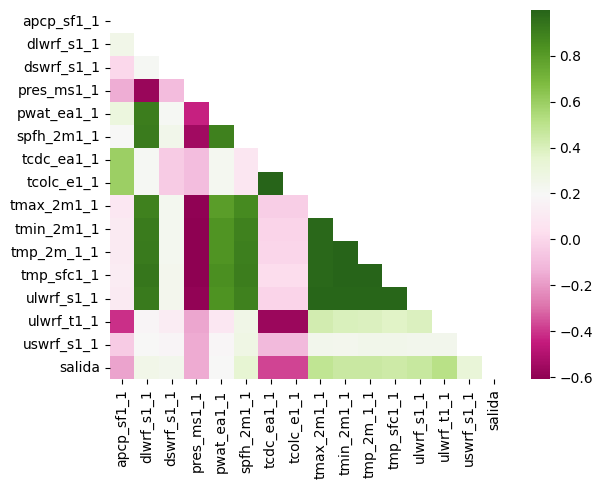

In [7]:
corr = disp_df_eda.corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) 
sns.heatmap(lower_tri, xticklabels=corr.columns, yticklabels=corr.columns, cmap= "PiYG" )

Según el gráfico podemos observar que existe correlación entre diferentes variables, tanto positiva como negativamente. Podemos observar que las variables que mayor correlacción positiva presentan son aquellas correspondientes a la temperatura (tmax_2m1,...,tmp_sfc1) con la variable de ulwrf_t1. Por otro lado, las variables que presentan mayor correlacción negativa son las relacionadas con la presión atmosférica (pres_ms1) con las variables de temperatura (tmax_2m1,...,tmp_sfc1) y con la variable de ulwrf_t1.

Podria ser interesante eliminar las variables con mayor correlación entre sí para mejorar la predicción.

Usando el método .corr() obtenemos la matriz de correlación entre las variables. Para más adelante poder eliminar los atributos más correlacionados, añadimos sus índices a una lista (to_drop_num). El threshold de correlación que hemos utilizado es de 0.95. 

In [8]:
corr = disp_df.corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) 
to_drop = []
to_drop_num = []

for field in lower_tri:
    for index, row in lower_tri.iterrows():
        if row[field] > 0.95 or row[field] < -0.95:
            if index not in to_drop:
                to_drop.append(index)
                #insert the numeric index of the column to drop
                to_drop_num.append(disp_df.columns.get_loc(index))

print("Eliminamos un total de ", len(to_drop), " columnas")
print("Los atributos que superán el threshold de correlación son:",to_drop)


Eliminamos un total de  51  columnas
Los atributos que superán el threshold de correlación son: ['dlwrf_s2_1', 'dlwrf_s3_1', 'dlwrf_s4_1', 'dlwrf_s5_1', 'dswrf_s3_1', 'uswrf_s2_1', 'dswrf_s5_1', 'pres_ms2_1', 'pres_ms3_1', 'pres_ms4_1', 'pres_ms5_1', 'pwat_ea2_1', 'pwat_ea3_1', 'pwat_ea4_1', 'pwat_ea5_1', 'spfh_2m2_1', 'spfh_2m3_1', 'spfh_2m4_1', 'spfh_2m5_1', 'tcolc_e1_1', 'tcolc_e2_1', 'tcolc_e3_1', 'tcolc_e4_1', 'tcolc_e5_1', 'tmax_2m2_1', 'tmin_2m1_1', 'tmin_2m2_1', 'tmin_2m3_1', 'tmp_2m_1_1', 'tmp_2m_2_1', 'tmp_sfc1_1', 'tmp_sfc2_1', 'ulwrf_s1_1', 'ulwrf_s2_1', 'ulwrf_s3_1', 'tmax_2m3_1', 'tmax_2m4_1', 'tmax_2m5_1', 'tmin_2m4_1', 'tmin_2m5_1', 'tmp_2m_3_1', 'tmp_2m_4_1', 'tmp_2m_5_1', 'tmp_sfc3_1', 'tmp_sfc5_1', 'ulwrf_s5_1', 'tmp_sfc4_1', 'ulwrf_s4_1', 'ulwrf_t3_1', 'ulwrf_t5_1', 'uswrf_s5_1']


Con esto podemos observar que la mayoría de variables tienen una alta correlación con otras variables, por lo que es posible que no aporten información relevante para la predicción.

### Detección de valores atípicos

Como hemos comentado anteriormente, con el método .describe() hemos podido observar que algunos campos presentan outliers (por ejemplo, en los campos relacionados con las precipitaciones 'apcp_sfx'). Podría ser interesante eliminar estos outliers para mejorar la predicción.

In [9]:
disp_df_wo_outliers = disp_df.copy()
# Quitamos la variable de salida
disp_df_wo_outliers.drop("salida", axis=1, inplace=True)
        
disp_df_std = disp_df_wo_outliers.std()
disp_df_mean = disp_df_wo_outliers.mean()
anomaly_cut_off = disp_df_std * 2
lower_limit  = disp_df_mean - anomaly_cut_off
upper_limit = disp_df_mean + anomaly_cut_off

for index, row in disp_df_wo_outliers.iterrows():
    if row.iloc[0] < lower_limit.iloc[0] or row.iloc[0] > upper_limit.iloc[0]:
        disp_df_wo_outliers.drop(index, inplace=True)

# Observamos los rangos de cada una de las variables
disp_df_wo_outliers.describe()


,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,dlwrf_s5_1,...,ulwrf_t1_1,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1
count,4230.000000,4230.000000,4230.000000,4230.000000,4230.000000,4230.000000,4230.000000,4230.000000,4230.000000,4230.000000,...,4230.000000,4230.000000,4230.000000,4230.000000,4230.000000,4230.000000,4230.000000,4230.000000,4230.000000,4230.000000
mean,0.259614,0.154905,0.336099,0.235047,0.451204,314.641517,315.409871,322.937716,342.664584,342.105670,...,250.036040,249.136546,253.141453,262.808056,261.671619,0.077799,39.238491,77.151429,127.586568,99.829207
std,0.742976,0.614578,1.305752,1.015293,1.774796,55.269262,57.582609,58.578856,60.965630,60.811938,...,33.966830,35.100774,35.151897,38.703839,38.337437,0.258245,25.963549,30.256642,39.502473,34.899557
min,0.000000,0.000000,0.000000,0.000000,0.000000,158.971770,160.032903,165.524543,183.671312,186.342961,...,104.671267,113.559602,118.679132,121.308241,121.951425,0.000000,0.181818,3.181818,4.363636,2.545455
25%,0.000000,0.000000,0.000000,0.000000,0.000000,268.817731,266.617597,274.094299,292.603136,291.860622,...,232.744513,232.472175,235.969352,247.077783,244.740406,0.000000,14.363636,54.386364,109.545455,75.363636
50%,0.000000,0.000000,0.000000,0.000000,0.000000,317.834014,318.926995,325.961816,344.859621,344.165780,...,254.374614,254.382005,258.233849,271.569437,270.119333,0.000000,36.363636,80.454545,137.000000,105.590909
75%,0.064318,0.033636,0.088182,0.022727,0.061818,364.124166,367.786384,376.747921,398.479377,397.905694,...,275.348900,275.696218,279.347739,290.653478,290.077095,0.000000,62.545455,103.431818,155.454545,129.727273
max,5.151818,13.916364,28.399091,26.381818,36.875455,426.173970,427.486894,429.693146,455.566337,453.910406,...,318.245345,311.991660,315.569164,328.920274,327.253141,1.000000,92.272727,192.636364,450.636364,313.909091


Podemos observar que eliminando los outliers, se reduce el rango de las variables aunque los datos siguen siendo muy dispares. Sin embargo, no vemos apropiado eliminar más outliers ya que perderíamos demasiada información.

# Preparación de datos


## Train, test y validación

Dividimos los datos en los conjuntos de train y test. A su vez dividimos el conjunto de train en train y validation para preparar las comparaciones entre los diferentes modelos.

In [10]:
train = disp_df.iloc[:10*365]
test = disp_df.iloc[10*365:]

X_disp = disp_df.iloc[:, :75]
Y_disp = disp_df.iloc[:, 75]

train = disp_df.iloc[:10*365]
test = disp_df.iloc[10*365:]

X_train = train.iloc[:, :75]
Y_train = train.iloc[:, 75]

X_test = test.iloc[:, :75]
Y_test = test.iloc[:, 75]

train_train = train.iloc[:8*365]
train_validation = train.iloc[8*365:]

X_train_train = train_train.iloc[:, :75]
Y_train_train = train_train.iloc[:, 75]
X_train_validation = train_validation.iloc[:, :75]
Y_train_validation = train_validation.iloc[:, 75]


## Datos comunes

### Normalización

Normalizamos los datos de train, test y validation para que todos los datos estén en el mismo rango.

In [11]:
scaler_x = StandardScaler()
X_train_norm = scaler_x.fit_transform(X_train)
X_test_norm = scaler_x.transform(X_test)

scaler_y = StandardScaler()
Y_train_norm = scaler_y.fit_transform(Y_train.values.reshape(-1, 1)).ravel()
Y_test_norm = scaler_y.transform(Y_test.values.reshape(-1, 1)).ravel()


In [12]:
scaler_x = StandardScaler()
X_train_train_norm = scaler_x.fit_transform(X_train_train)
X_train_validation_norm = scaler_x.transform(X_train_validation)

scaler_y = StandardScaler()
Y_train_train_norm = scaler_y.fit_transform(Y_train_train.values.reshape(-1, 1)).ravel()
Y_train_validation_norm = scaler_y.transform(Y_train_validation.values.reshape(-1, 1)).ravel()

### Predifined Split

In [13]:
N_train_train = 365*8
N_train_val = 365*2

train_fold = [-1]*N_train_train + [0]*N_train_val

split_index = PredefinedSplit(test_fold=train_fold)


# Baseline

Creamos una tanda de modelos con los parámetros por defecto para tener un punto de partida y poder comparar los resultados de los modelos que entrenemos posteriormente. Para los diferentes modelos tendremos en cuenta el RMSE y el MAE. Además, tendremos en cuenta el tiempo de ejecución de cada modelo. Para el KNN y el SVM, los datos tenrán que normalizarse para entrenar el modelo y desnormalizarse para las métricas de evaluación.

## Creación de un modelo dummy

Creamos un modelo dummy que el resto de modelo debe superar para ser considerado como un buen modelo.

In [14]:
dummy = DummyRegressor(strategy="median")
dummy.fit(X_train_train, Y_train_train)
dummy_pred = dummy.predict(X_train_validation)

dummy_mae = mean_absolute_error(Y_train_validation, dummy_pred)
print("dummy MAE: ", dummy_mae)

dummy_rmse = np.sqrt(mean_squared_error(Y_train_validation,dummy_pred))
print("dummy RMSE: ", dummy_rmse)

dummy_score = dummy.score(X_train_validation, Y_train_validation)
print("dummy score: ", dummy_score)

dummy MAE:  6720947.2602739725
dummy RMSE:  7809144.902737563
dummy score:  -0.003940687559321532


## Métodos Básicos

### KNeighborsRegressor 

In [15]:
start = time.time()

KNN_reg = KNeighborsRegressor()

KNN_reg.fit(X_train_train_norm, Y_train_train_norm)
KNN_reg_pred_norm = KNN_reg.predict(X_train_validation_norm)
KNN_reg_pred = scaler_y.inverse_transform(KNN_reg_pred_norm.reshape(-1, 1)).ravel()

end = time.time()

# Métricas
KNN_reg_mae = mean_absolute_error(Y_train_validation, KNN_reg_pred)
print("MAE: ", KNN_reg_mae)

KNN_reg_rmse = np.sqrt(mean_squared_error(Y_train_validation, KNN_reg_pred))
print("RMSE: ", KNN_reg_rmse)


print("Puntuación: ", KNN_reg.score(X_train_validation_norm, Y_train_validation_norm))
print("Tiempo de ejecución: ", end - start)

MAE:  2536714.7671232875
RMSE:  3675153.3534838464
Puntuación:  0.777642376391267
Tiempo de ejecución:  0.14735984802246094


### Árbol de regresión

In [16]:
start = time.time()

tree_reg = DecisionTreeRegressor(random_state=2)
tree_reg.fit(X_train_train, Y_train_train)
tree_reg_pred = tree_reg.predict(X_train_validation)

end = time.time()

tree_reg_mae = mean_absolute_error(Y_train_validation, tree_reg_pred)
print("MAE: ", tree_reg_mae)

tree_reg_rmse = np.sqrt(mean_squared_error(Y_train_validation, tree_reg_pred))
print("RMSE: ", tree_reg_rmse)

print("Puntuación: ", tree_reg.score(X_train_validation, Y_train_validation))
print("Tiempo de ejecución: ", end - start)


MAE:  3344148.493150685
RMSE:  4829894.676721137
Puntuación:  0.6159600420419615
Tiempo de ejecución:  0.3841562271118164


### Regresión lineal

In [17]:
start = time.time()

li_reg = LinearRegression()
li_reg.fit(X_train_train, Y_train_train)
li_reg_pred = li_reg.predict(X_train_validation)

end = time.time()

li_reg_mae = mean_absolute_error(Y_train_validation, li_reg_pred)
print("MAE: ", li_reg_mae)

li_reg_rmse = np.sqrt(mean_squared_error(Y_train_validation, li_reg_pred))
print("RMSE: ", li_reg_rmse)

print("Puntuación: ", li_reg.score(X_train_validation, Y_train_validation))
print("Tiempo de ejecución: ", end - start)


MAE:  2265683.8029644764
RMSE:  3268115.476041282
Puntuación:  0.8241688243985801
Tiempo de ejecución:  0.0964205265045166


## Métodos Avanzados

### SVM

In [18]:
start = time.time()

svm = SVR()

svm.fit(X_train_train_norm, Y_train_train_norm)
y_pred_norm = svm.predict(X_train_validation_norm)
y_pred = scaler_y.inverse_transform(y_pred_norm.reshape(-1, 1)).ravel()

end = time.time()

svm_mae = mean_absolute_error(Y_train_validation, y_pred)
print("MAE: ", svm_mae)

svm_rmse = np.sqrt(mean_squared_error(Y_train_validation, y_pred))
print("RMSE: ", svm_rmse)

print("Puntuación: ", svm.score(X_train_validation_norm, Y_train_validation_norm))
print("Tiempo de ejecución: ", end - start)


MAE:  2224652.794901519
RMSE:  3353514.5586067806
Puntuación:  0.8148594775863227
Tiempo de ejecución:  1.8233215808868408


### Random Forest

In [19]:
start = time.time()

rfr = RandomForestRegressor(random_state=2)
rfr.fit(X_train_train, Y_train_train)
rfr_pred = rfr.predict(X_train_validation)

end = time.time()

rfr_mae = mean_absolute_error(Y_train_validation, rfr_pred)
print("MAE: ", rfr_mae)

rfr_rmse = np.sqrt(mean_squared_error(Y_train_validation, rfr_pred))
print("RMSE: ", rfr_rmse)

print("Puntuación: ", rfr.score(X_train_validation, Y_train_validation))
print("Tiempo de ejecución: ", end - start)


MAE:  2278659.197260274
RMSE:  3341026.470443267
Puntuación:  0.8162357926282553
Tiempo de ejecución:  36.48603296279907


# Ajuste de hiperparámetros por búsqueda en cuadrícula

Para mejorar los resultados de los modelos, ajustaremos los hiperparámetros de los modelos que hemos utilizado anteriormente. Para ello, utilizaremos la búsqueda en cuadrícula. En cada modelo, hemos tomado los hiperparámetros principales que consideramos que pueden influir en el resultado del modelo. En el GridSearch utilizamos como cv el split_index para separar los conjuntos de train y validation, como scoring el RMSE y el MAE y para el refit el RMSE.

Evaluamos los resultados de los modelos con los mejores hiperparámetros y comparamos con los resultados de los modelos con los parámetros por omisión.

## Métodos básicos

### KNeighborsRegressor

In [20]:
start = time.time()

param_grid = {
    'n_neighbors': np.arange(1, 20), 
    'weights': ['uniform', 'distance'], 
    'p': [1, 2, 3, 4]
    }

grid = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=param_grid,
    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'], 
    refit='neg_root_mean_squared_error',
    cv=split_index,
    verbose=3,
    n_jobs=-1)

grid.fit(X_train_norm, Y_train_norm)

end = time.time()

knn_best_params = grid.best_params_

print("Tiempo de ejecución: ", end - start)
print("Mejor modelo: ", grid.best_estimator_)


Fitting 1 folds for each of 152 candidates, totalling 152 fits
Tiempo de ejecución:  78.84862661361694
Mejor modelo:  KNeighborsRegressor(n_neighbors=19, p=1, weights='distance')


Evaluación del modelo

In [21]:
# Entrenar modelo
mejor_modelo = KNeighborsRegressor(**knn_best_params)
mejor_modelo.fit(X_train_train_norm, Y_train_train_norm)

y_pred = mejor_modelo.predict(X_train_validation_norm)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()


# Evaluacion
mejor_modelo_mae = mean_absolute_error(Y_train_validation, y_pred)
print("MAE: ", mejor_modelo_mae)
mejor_modelo_rmse = np.sqrt(mean_squared_error(Y_train_validation, y_pred))
print("RMSE: ", mejor_modelo_rmse)
print("Puntuación: ", mejor_modelo.score(X_train_validation_norm, Y_train_validation_norm))

MAE:  2387481.5550863626
RMSE:  3461006.5864845184
Puntuación:  0.8028004387936578


### Árboles de regresión

In [22]:
start = time.time()

param_grid = {
    'max_depth': range(2, 16, 2),
    'min_samples_split': range(2, 16, 2)
}

grid = GridSearchCV(estimator=DecisionTreeRegressor(random_state=2),
                    param_grid=param_grid,
                    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'], 
                    refit='neg_root_mean_squared_error',
                    cv=split_index, 
                    n_jobs=-1,
                    verbose=3)

grid.fit(X_train, Y_train)

end = time.time()

tree_reg_best_params = grid.best_params_


print("Tiempo de ejecución: ", end - start)
print("Mejor modelo: ", grid.best_estimator_)

Fitting 1 folds for each of 49 candidates, totalling 49 fits
[CV 1/1] END max_depth=2, min_samples_split=2; neg_mean_absolute_error: (test=-3244362.219) neg_root_mean_squared_error: (test=-4266458.220) total time=   0.0s
[CV 1/1] END max_depth=2, min_samples_split=4; neg_mean_absolute_error: (test=-3244362.219) neg_root_mean_squared_error: (test=-4266458.220) total time=   0.0s
[CV 1/1] END max_depth=2, min_samples_split=6; neg_mean_absolute_error: (test=-3244362.219) neg_root_mean_squared_error: (test=-4266458.220) total time=   0.0s
[CV 1/1] END max_depth=2, min_samples_split=8; neg_mean_absolute_error: (test=-3244362.219) neg_root_mean_squared_error: (test=-4266458.220) total time=   0.1s
[CV 1/1] END max_depth=2, min_samples_split=10; neg_mean_absolute_error: (test=-3244362.219) neg_root_mean_squared_error: (test=-4266458.220) total time=   0.1s
[CV 1/1] END max_depth=2, min_samples_split=12; neg_mean_absolute_error: (test=-3244362.219) neg_root_mean_squared_error: (test=-4266458.2

Evaluación del modelo

In [23]:
# Entrenar modelo
mejor_modelo = DecisionTreeRegressor(**tree_reg_best_params)
mejor_modelo.fit(X_train_train, Y_train_train)

y_pred = mejor_modelo.predict(X_train_validation)


# Evaluacion
mejor_modelo_mae = mean_absolute_error(Y_train_validation, y_pred)
print("MAE: ", mejor_modelo_mae)
mejor_modelo_rmse = np.sqrt(mean_squared_error(Y_train_validation, y_pred))
print("RMSE: ", mejor_modelo_rmse)
print("Puntuación: ", mejor_modelo.score(X_train_validation, Y_train_validation))

MAE:  2632126.199774195
RMSE:  3739779.928136276
Puntuación:  0.7697534213990718


### Regresión lineal

In [24]:
start = time.time()

param_grid ={
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
    
}

grid = GridSearchCV(
    estimator=LinearRegression(),
    param_grid=param_grid,
    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'], 
    refit='neg_root_mean_squared_error',
    cv=split_index,
    n_jobs=-1,
    verbose=3)


grid.fit(X_train, Y_train)

end = time.time()

li_reg_best_params = grid.best_params_


print("Tiempo de ejecución: ", end - start)
print("Mejor modelo: ", grid.best_estimator_)

Fitting 1 folds for each of 8 candidates, totalling 8 fits
Tiempo de ejecución:  0.9455056190490723
Mejor modelo:  LinearRegression()


Evaluación del modelo

In [25]:
# Entrenar modelo
mejor_modelo = LinearRegression(**li_reg_best_params)
mejor_modelo.fit(X_train_train, Y_train_train)

y_pred = mejor_modelo.predict(X_train_validation)


# Evaluacion
mejor_modelo_mae = mean_absolute_error(Y_train_validation, y_pred)
print("MAE: ", mejor_modelo_mae)
mejor_modelo_rmse = np.sqrt(mean_squared_error(Y_train_validation, y_pred))
print("RMSE: ", mejor_modelo_rmse)
print("Puntuación: ", mejor_modelo.score(X_train_validation, Y_train_validation))

MAE:  2265683.8029644764
RMSE:  3268115.476041282
Puntuación:  0.8241688243985801


## Métodos avanzados

### SVM

In [26]:
start = time.time()

param_grid ={
    'gamma': ['scale', 'auto'],
    'C': [0.1, 1, 10, 100, 1000],
}

grid = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid,
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'], 
    refit='neg_root_mean_squared_error',
    cv=split_index,
    n_jobs=-1,
    verbose=3)


grid.fit(X_train_norm, Y_train_norm)

end = time.time()

svm_best_params = grid.best_params_

# print(grid.score(X_train_validation, Y_train_validation))
print("Tiempo de ejecución: ", end - start)
print("Mejor modelo: ", grid.best_estimator_)


Fitting 1 folds for each of 10 candidates, totalling 10 fits
Tiempo de ejecución:  39.5477933883667
Mejor modelo:  SVR(C=1, gamma='auto')


Evaluación del modelo

In [27]:
# Entrenar modelo    
mejor_modelo = SVR(**svm_best_params) 
mejor_modelo.fit(X_train_train_norm, Y_train_train_norm)

y_pred = mejor_modelo.predict(X_train_validation_norm)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()


# Evaluacion
svm_mae = mean_absolute_error(Y_train_validation, y_pred)
print("MAE: ", svm_mae)

svm_rmse = np.sqrt(mean_squared_error(Y_train_validation, y_pred))
print("RMSE: ", svm_rmse)

print("Puntuación: ", mejor_modelo.score(X_train_validation_norm, Y_train_validation_norm))

MAE:  2224652.7949015237
RMSE:  3353514.5586067853
Puntuación:  0.8148594775863223


### Random Forest

In [28]:
start = time.time()

param_grid ={
    'n_estimators': range(10, 100, 10),
    'max_depth': range(2, 16, 2),
    'max_features': ['sqrt', 'log2', 25],
}

grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=2),
    param_grid=param_grid,
    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'], 
    refit='neg_root_mean_squared_error',
    cv= split_index,
    n_jobs=-1,
    verbose=3)

grid.fit(X_train, Y_train)

end = time.time()

rfr_best_params = grid.best_params_


print("Tiempo de ejecución: ", end - start)
print("Mejor modelo: ", grid.best_estimator_)

Fitting 1 folds for each of 189 candidates, totalling 189 fits
Tiempo de ejecución:  55.28126358985901
Mejor modelo:  RandomForestRegressor(max_depth=10, max_features='log2', n_estimators=70,
                      random_state=2)


Evaluación del modelo

In [29]:
# Entrenar modelo
mejor_modelo = RandomForestRegressor(**rfr_best_params)
mejor_modelo.fit(X_train_train, Y_train_train)

y_pred = mejor_modelo.predict(X_train_validation)


# Evaluacion
mejor_modelo_mae = mean_absolute_error(Y_train_validation, y_pred)
print("MAE: ", mejor_modelo_mae)
mejor_modelo_rmse = np.sqrt(mean_squared_error(Y_train_validation, y_pred))
print("RMSE: ", mejor_modelo_rmse)
print("Puntuación: ", mejor_modelo.score(X_train_validation, Y_train_validation))

MAE:  2206593.7184577873
RMSE:  3250147.2697244775
Puntuación:  0.8260969604763064


### Conclusiones

El mejor modelo es el Random Forest con max_depth=10, max_features = log2 y n_estimators = 70. El tiempo de ejecución en ninguno de ellos es demasiado grande como para tenerlo en cuenta como factor decisivo para elegir un modelo u otro. Aunque nos quedaría la posibilidad de que si un modelo tardase demasiado en realizar el HPO, podríamos realizar un RandomSearch con un budget más reducido.

Nos ha llamado la atención que en el caso del SVM, los mejores parámetros son los parámetros por defecto. Por lo que no hemos encontrado mejoras con el modelo de baseline.

# Reducción de dimensionalidad

En base a lo comentado en el EDA, hemos decidido eliminar las variables que presentan una correlación mayor de 0.95 con otras variables. Para ello, hemos montado un Pipeline utilizando un ColumnTransformer para seleccionar las columnas que queremos eliminar.

## Métodos básicos

### KNeighborsRegressor

In [30]:
knn_pipe = Pipeline([('Transform', ColumnTransformer(transformers=[('Corr_drop','drop',to_drop_num)],remainder='passthrough')), ('KNN', KNeighborsRegressor())])

start = time.time()


param_grid = {
    'KNN__n_neighbors': np.arange(1, 20), 
    'KNN__weights': ['uniform', 'distance'], 
    'KNN__p': [1, 2, 3, 4]
    }

grid = GridSearchCV(
    estimator=knn_pipe,
    param_grid=param_grid,
    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'], 
    refit='neg_root_mean_squared_error',
    cv=split_index,
    verbose=3,
    n_jobs=-1)

np.random.seed(2)
grid.fit(X_train_norm, Y_train_norm)

end = time.time()

knn_best_params_pipe = grid.best_params_

print("Tiempo de ejecución: ", end - start)
print("Mejor modelo: ", grid.best_estimator_)


Fitting 1 folds for each of 152 candidates, totalling 152 fits
Tiempo de ejecución:  22.494587182998657
Mejor modelo:  Pipeline(steps=[('Transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Corr_drop', 'drop',
                                                  [6, 7, 8, 9, 12, 71, 14, 16,
                                                   17, 18, 19, 21, 22, 23, 24,
                                                   26, 27, 28, 29, 35, 36, 37,
                                                   38, 39, 41, 45, 46, 47, 50,
                                                   51, ...])])),
                ('KNN',
                 KNeighborsRegressor(n_neighbors=19, p=1, weights='distance'))])


In [31]:
# Entrenar modelo
mejor_modelo = Pipeline([('Transform', ColumnTransformer(transformers=[('Corr_drop','drop',to_drop_num)],remainder='passthrough')), ('KNN', KNeighborsRegressor())])
mejor_modelo.set_params(**knn_best_params_pipe)
mejor_modelo.fit(X_train_train_norm, Y_train_train_norm)

y_pred = mejor_modelo.predict(X_train_validation_norm)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()


# Evaluacion
mejor_modelo_mae = mean_absolute_error(Y_train_validation, y_pred)
print("MAE: ", mejor_modelo_mae)
mejor_modelo_rmse = np.sqrt(mean_squared_error(Y_train_validation, y_pred))
print("RMSE: ", mejor_modelo_rmse)
print("Puntuación: ", mejor_modelo.score(X_train_validation_norm, Y_train_validation_norm))

MAE:  2459788.591595502
RMSE:  3612687.702072602
Puntuación:  0.7851368521343325


### Árbol de regresión

In [32]:
tree_pipe = Pipeline([('Transform', ColumnTransformer(transformers=[('Corr_drop','drop',to_drop_num)],remainder='passthrough')), ('Tree', DecisionTreeRegressor())])

start = time.time()

param_grid = {
    'Tree__max_depth': range(2, 16, 2),
    'Tree__max_features': ['sqrt', 'log2', 25],
    'Tree__min_samples_split': range(2, 16, 2),
    }

grid = GridSearchCV(
    estimator=tree_pipe,
    param_grid=param_grid,
    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'],
    refit='neg_root_mean_squared_error',
    cv=split_index,
    verbose=3,
    n_jobs=-1)

np.random.seed(2)
grid.fit(X_train, Y_train)

end = time.time()

tree_best_params_pipe = grid.best_params_

print("Tiempo de ejecución: ", end - start)
print("Mejor modelo: ", grid.best_estimator_)

Fitting 1 folds for each of 147 candidates, totalling 147 fits
Tiempo de ejecución:  0.9063262939453125
Mejor modelo:  Pipeline(steps=[('Transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Corr_drop', 'drop',
                                                  [6, 7, 8, 9, 12, 71, 14, 16,
                                                   17, 18, 19, 21, 22, 23, 24,
                                                   26, 27, 28, 29, 35, 36, 37,
                                                   38, 39, 41, 45, 46, 47, 50,
                                                   51, ...])])),
                ('Tree', DecisionTreeRegressor(max_depth=4, max_features=25))])


Evalución del modelo

In [33]:
# Entrenar modelo
mejor_modelo = Pipeline([('Transform', ColumnTransformer(transformers=[('Corr_drop','drop',to_drop_num)],remainder='passthrough')), ('Tree', DecisionTreeRegressor())])
mejor_modelo.set_params(**tree_best_params_pipe)
mejor_modelo.fit(X_train_train, Y_train_train)

y_pred = mejor_modelo.predict(X_train_validation)


# Evaluacion
mejor_modelo_mae = mean_absolute_error(Y_train_validation, y_pred)
print("MAE: ", mejor_modelo_mae)
mejor_modelo_rmse = np.sqrt(mean_squared_error(Y_train_validation, y_pred))
print("RMSE: ", mejor_modelo_rmse)
print("Puntuación: ", mejor_modelo.score(X_train_validation, Y_train_validation))


MAE:  2659221.753340806
RMSE:  3750909.8039515964
Puntuación:  0.7683809186593316


### Regresión Linear

In [34]:
li_reg_pipe = Pipeline([('Transform', ColumnTransformer(transformers=[('Corr_drop','drop',to_drop_num)],remainder='passthrough')), ('li_reg', LinearRegression())])

start = time.time()

param_grid = {
    'li_reg__fit_intercept': [True, False],
    'li_reg__positive': [True, False],
    'li_reg__copy_X': [True, False],
}

grid = GridSearchCV(
    estimator=li_reg_pipe,
    param_grid=param_grid,
    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'],
    refit='neg_root_mean_squared_error',
    cv=split_index,
    verbose=3,
    n_jobs=-1)

np.random.seed(2)
grid.fit(X_train, Y_train)

end = time.time()

li_reg_best_params_pipe = grid.best_params_

print("Tiempo de ejecución: ", end - start)
print("Mejor modelo: ", grid.best_estimator_)

Fitting 1 folds for each of 8 candidates, totalling 8 fits
Tiempo de ejecución:  0.24258160591125488
Mejor modelo:  Pipeline(steps=[('Transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Corr_drop', 'drop',
                                                  [6, 7, 8, 9, 12, 71, 14, 16,
                                                   17, 18, 19, 21, 22, 23, 24,
                                                   26, 27, 28, 29, 35, 36, 37,
                                                   38, 39, 41, 45, 46, 47, 50,
                                                   51, ...])])),
                ('li_reg', LinearRegression())])


Evaluación del modelo

In [35]:
# Entrenar modelo
mejor_modelo = Pipeline([('Transform', ColumnTransformer(transformers=[('Corr_drop','drop',to_drop_num)],remainder='passthrough')), ('li_reg', LinearRegression())])
mejor_modelo.set_params(**li_reg_best_params_pipe)
mejor_modelo.fit(X_train_train, Y_train_train)

y_pred = mejor_modelo.predict(X_train_validation)


# Evaluacion
mejor_modelo_mae = mean_absolute_error(Y_train_validation, y_pred) 
print("MAE: ", mejor_modelo_mae)
mejor_modelo_rmse = np.sqrt(mean_squared_error(Y_train_validation, y_pred))
print("RMSE: ", mejor_modelo_rmse)
print("Puntuación: ", mejor_modelo.score(X_train_validation, Y_train_validation))

MAE:  2462113.5196996415
RMSE:  3498262.6668375847
Puntuación:  0.7985320704145327


## Métodos avanzados

### SVM

In [36]:
svm_pipe = Pipeline([('Transform', ColumnTransformer(transformers=[('Corr_drop','drop',to_drop_num)],remainder='passthrough')), ('svm', SVR())])

start = time.time()

param_grid = {
    'svm__gamma': ['scale', 'auto'],
    'svm__C': [0.1, 1, 10, 100, 1000],
    }

grid = GridSearchCV(
    estimator=svm_pipe,
    param_grid=param_grid,
    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'],
    refit='neg_root_mean_squared_error',
    cv=split_index,
    verbose=3,
    n_jobs=-1)

np.random.seed(2)
grid.fit(X_train_norm, Y_train_norm)

end = time.time()

svm_best_params_pipe = grid.best_params_

print("Tiempo de ejecución: ", end - start)
print("Mejor modelo: ", grid.best_estimator_)

Fitting 1 folds for each of 10 candidates, totalling 10 fits
Tiempo de ejecución:  45.86603856086731
Mejor modelo:  Pipeline(steps=[('Transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Corr_drop', 'drop',
                                                  [6, 7, 8, 9, 12, 71, 14, 16,
                                                   17, 18, 19, 21, 22, 23, 24,
                                                   26, 27, 28, 29, 35, 36, 37,
                                                   38, 39, 41, 45, 46, 47, 50,
                                                   51, ...])])),
                ('svm', SVR(C=1, gamma='auto'))])


Evaluación del modelo

In [37]:
# Entrenar modelo
mejor_modelo = Pipeline([('Transform', ColumnTransformer(transformers=[('Corr_drop','drop',to_drop_num)],remainder='passthrough')), ('svm', SVR())])
mejor_modelo.set_params(**svm_best_params_pipe)
mejor_modelo.fit(X_train_train_norm, Y_train_train_norm)

y_pred = mejor_modelo.predict(X_train_validation_norm)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1))


# Evaluacion
mejor_modelo_mae = mean_absolute_error(Y_train_validation, y_pred)
print("MAE: ", mejor_modelo_mae)
mejor_modelo_rmse = np.sqrt(mean_squared_error(Y_train_validation, y_pred))
print("RMSE: ", mejor_modelo_rmse)
print("Puntuación: ", mejor_modelo.score(X_train_validation_norm, Y_train_validation_norm))

MAE:  2324872.2868100656
RMSE:  3552839.9888779204
Puntuación:  0.792196724211542


### Random Forest

In [38]:
rfr_pipe = Pipeline([('Transform', ColumnTransformer(transformers=[('Corr_drop','drop',to_drop_num)],remainder='passthrough')), ('rfr', RandomForestRegressor())])

start = time.time()

param_grid = {
    'rfr__n_estimators': range(10, 100, 10),
    'rfr__max_depth': range(2, 16, 2),
    'rfr__max_features': ['sqrt', 'log2', 25]
    }

grid = GridSearchCV(
    estimator=rfr_pipe,
    param_grid=param_grid,
    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'],
    refit='neg_root_mean_squared_error',
    cv=split_index,
    verbose=3,
    n_jobs=-1)

np.random.seed(2)
grid.fit(X_train, Y_train)

end = time.time()
 
rfr_best_params_pipe = grid.best_params_

print("Tiempo de ejecución: ", end - start)
print("Mejor modelo: ", grid.best_estimator_)

Fitting 1 folds for each of 189 candidates, totalling 189 fits
Tiempo de ejecución:  33.171375036239624
Mejor modelo:  Pipeline(steps=[('Transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Corr_drop', 'drop',
                                                  [6, 7, 8, 9, 12, 71, 14, 16,
                                                   17, 18, 19, 21, 22, 23, 24,
                                                   26, 27, 28, 29, 35, 36, 37,
                                                   38, 39, 41, 45, 46, 47, 50,
                                                   51, ...])])),
                ('rfr',
                 RandomForestRegressor(max_depth=10, max_features='log2',
                                       n_estimators=50))])


Evaluación del modelo

In [39]:
# Entrenar modelo
mejor_modelo = Pipeline([('Transform', ColumnTransformer(transformers=[('Corr_drop','drop',to_drop_num)],remainder='passthrough')), ('rfr', RandomForestRegressor())])
mejor_modelo.set_params(**rfr_best_params_pipe)
mejor_modelo.fit(X_train_train, Y_train_train)

y_pred = mejor_modelo.predict(X_train_validation)


# Evaluacion
mejor_modelo_mae = mean_absolute_error(Y_train_validation, y_pred)
print("MAE: ", mejor_modelo_mae)
mejor_modelo_rmse = np.sqrt(mean_squared_error(Y_train_validation, y_pred))
print("RMSE: ", mejor_modelo_rmse)
print("Puntuación: ", mejor_modelo.score(X_train_validation, Y_train_validation))

MAE:  2347669.625544
RMSE:  3440033.979958479
Puntuación:  0.8051831317556385


### Conclusiones

Aún reduciendo la dimensionalidad, los resultados de los modelos no mejoran con respecto al dataframe completo. Por lo que no es necesario reducir la dimensionalidad para mejorar los resultados.

# Modelo final

Como mejor modelo, tomamos el Random Forest con los hiperparámetros max_depth=10, max_features = log2 y n_estimators = 70. Por tanto entrenamos el modelo con los datos de train y validación y lo evaluamos con los datos de test. Como observamos antes, se toma el dataframe completo ya que se obtiene mejores resultado son él.

## Random Forest

In [40]:
rfr = RandomForestRegressor(**rfr_best_params)
rfr.fit(X_train, Y_train)

rfr_pred = rfr.predict(X_test)

# Evaluacion
rfr_mae = mean_absolute_error(Y_test, rfr_pred)
print("MAE: ", rfr_mae)
rfr_rmse = np.sqrt(mean_squared_error(Y_test, rfr_pred))
print("RMSE: ", rfr_rmse)
print("Puntuación: ", rfr.score(X_test, Y_test))

MAE:  2131407.974357523
RMSE:  3084017.270834608
Puntuación:  0.8291687473871651


Como era de esperar, al entrenarlo con un conjunto mayor de datos, su error se reduce.

## Entrenamiento del modelo final

Creamos el modelo final con los hiperparámetros que hemos obtenido en el HPO y lo entrenamos con todo el conjunto de datos disponibles. Una vez entrenado lo guardamos en un .pkl para poder utilizarlo en otros ficheros.

In [41]:
rfr = RandomForestRegressor(**rfr_best_params)
rfr.fit(X_disp, Y_disp)

filename = 'mejor_modelo.pkl'
pickle.dump(mejor_modelo, open(filename, 'wb'))